<div style="font-size: 16px; font-weight: 500; line-height: 1.4; font-style: italic; color: #6c757d; margin-bottom: 1em;">
  or, Ty Goes Into Far Too Much Detail About Cleaning Data
</div>

1. **[Introduction](#Introduction)**
2. **[Data cleaning](#Data-cleaning)**
3. **[Building the neural networks](#Building-the-neural-networks)**
4. **[Saving the final model](#Saving-the-final-model)**
5. **[Building the API](#Building-the-api)**

## Introduction

[LendingClub](https://www.lendingclub.com/) is the world's largest peer-to-peer lending platform. Until recently (through the end of 2018), LendingClub published a public dataset of all loans issued since the company's launch in 2007. I'm accessing the dataset [via Kaggle](https://www.kaggle.com/wordsforthewise/lending-club).

In [1]:
import pandas as pd

loans = pd.read_csv(
    "../input/lending-club/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv",
    low_memory=False,
)

loans.shape

(2260701, 151)

With 2,260,701 loans to look at and 151 potential variables, my goal is to create a neural network model to predict the fraction of an expected loan return that a prospective borrower will pay back. Afterward, I'll create a public API to serve that model.

## Data cleaning

I'll first look at the data dictionary (accessed from a [different Kaggle dataset](https://www.kaggle.com/wendykan/lending-club-loan-data)) to get an idea of how to create the desired output variable and which remaining features are available at the point of loan application (to avoid data leakage).

In [2]:
dictionary_df = pd.read_excel("../input/lending-club-loan-data/LCDataDictionary.xlsx")

# Drop blank rows, strip white space, convert to Python dictionary, fix one key name
dictionary_df.dropna(axis="index", inplace=True)
dictionary_df = dictionary_df.applymap(lambda x: x.strip())
dictionary_df.set_index("LoanStatNew", inplace=True)
dictionary = dictionary_df["Description"].to_dict()
dictionary["verification_status_joint"] = dictionary.pop("verified_status_joint")

# Print in order of dataset columns (which makes more sense than dictionary's order)
for col in loans.columns:
    print(f"•{col}: {dictionary[col]}")

# Hiding the output because it's quite a few lines, but feel free to take a peek by
# clicking the "Output" button

•id: A unique LC assigned ID for the loan listing.
•member_id: A unique LC assigned Id for the borrower member.
•loan_amnt: The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
•funded_amnt: The total amount committed to that loan at that point in time.
•funded_amnt_inv: The total amount committed by investors for that loan at that point in time.
•term: The number of payments on the loan. Values are in months and can be either 36 or 60.
•int_rate: Interest Rate on the loan
•installment: The monthly payment owed by the borrower if the loan originates.
•grade: LC assigned loan grade
•sub_grade: LC assigned loan subgrade
•emp_title: The job title supplied by the Borrower when applying for the loan.*
•emp_length: Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
•home_ownership: The home owner

For the output variable (the fraction of expected return that was recovered), I'll calculated the _expected return_ by multiplying the monthly payment amount (`installment`) by the number of payments on the loan (`term`), and I'll calculate the _amount actually received_ by summing the total principle, interest, late fees, and post-chargeoff gross recovery received (`total_rec_prncp`, `total_rec_int`, `total_rec_late_fee`, `recoveries`) and subtracting any collection fee (`collection_recovery_fee`).

In [3]:
cols_for_output = ["term", "installment", "total_rec_prncp", "total_rec_int", "total_rec_late_fee", "recoveries", "collection_recovery_fee"]

Several other columns contain either irrelevant demographic data or data not created until after a loan is accepted, so those will need to be removed. I'll hold onto `issue_d` (the month and year the loan was funded) for now, though, in case I want to compare variables to the date of the loan.

`emp_title` (the applicant's job title) _does_ seem relevant in the context of a loan, but it may have too many unique values to be useful.

In [4]:
loans["emp_title"].nunique()

512694

Too many unique values indeed. In a future version of this model I could perhaps try to generate a feature from this column by aggregating job titles into categories, but that effort may have a low return on investment, since there are already columns for annual income and length of employment.

Two other interesting columns that I'll also remove are `title` and `desc` ("description"), which are both freeform text entries written by the borrower. These could be fascinating subjects for natural language processing, but that's outside the scope of the current project. Perhaps in the future I could generate additional features from these fields using measures like syntactic complexity, word count, or keyword inclusion.

In [5]:
cols_to_drop = ["id", "member_id", "funded_amnt", "funded_amnt_inv", "int_rate", "grade", "sub_grade", "emp_title", "pymnt_plan", "url", "desc", "title", "zip_code", "addr_state", "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt", "total_pymnt_inv", "last_pymnt_d", "last_pymnt_amnt", "next_pymnt_d", "last_credit_pull_d", "last_fico_range_high", "last_fico_range_low", "policy_code", "hardship_flag", "hardship_type", "hardship_reason", "hardship_status", "deferral_term", "hardship_amount", "hardship_start_date", "hardship_end_date", "payment_plan_start_date", "hardship_length", "hardship_dpd", "hardship_loan_status", "orig_projected_additional_accrued_interest", "hardship_payoff_balance_amount", "hardship_last_payment_amount", "disbursement_method", "debt_settlement_flag", "debt_settlement_flag_date", "settlement_status", "settlement_date", "settlement_amount", "settlement_percentage", "settlement_term"]

loans = loans.drop(columns=cols_to_drop)

Before creating the output variable, however, I must take a closer look at `loan_status`, to see if any loans in the dataset are still open.

In [6]:
loans.groupby("loan_status")["loan_status"].count()

loan_status
Charged Off                                             268559
Current                                                 878317
Default                                                     40
Does not meet the credit policy. Status:Charged Off        761
Does not meet the credit policy. Status:Fully Paid        1988
Fully Paid                                             1076751
In Grace Period                                           8436
Late (16-30 days)                                         4349
Late (31-120 days)                                       21467
Name: loan_status, dtype: int64

For practical purposes, I'll consider loans with statuses that don't contain "Fully Paid" or "Charged Off" to still be open, so I'll remove those from the dataset. I'll also merge the "credit policy" columns with their matching status.

In [7]:
credit_policy = "Does not meet the credit policy. Status:"
len_credit_policy = len(credit_policy)
remove_credit_policy = (
    lambda status: status[len_credit_policy:]
    if credit_policy in str(status)
    else status
)
loans["loan_status"] = loans["loan_status"].map(remove_credit_policy)

rows_to_drop = loans[
    (loans["loan_status"] != "Charged Off") & (loans["loan_status"] != "Fully Paid")
].index
loans.drop(index=rows_to_drop, inplace=True)

loans.groupby("loan_status")["loan_status"].count()

loan_status
Charged Off     269320
Fully Paid     1078739
Name: loan_status, dtype: int64

Now to create the output variable. I'll start by checking the null counts of the variables involved.

In [8]:
loans[cols_for_output].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1348059 entries, 0 to 2260697
Data columns (total 7 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   term                     1348059 non-null  object 
 1   installment              1348059 non-null  float64
 2   total_rec_prncp          1348059 non-null  float64
 3   total_rec_int            1348059 non-null  float64
 4   total_rec_late_fee       1348059 non-null  float64
 5   recoveries               1348059 non-null  float64
 6   collection_recovery_fee  1348059 non-null  float64
dtypes: float64(6), object(1)
memory usage: 82.3+ MB


Every remaining row has each of these seven variables, but `term`'s data type is `object`, so that needs to be fixed first.

In [9]:
loans.groupby("term")["term"].count()

term
 36 months    1023181
 60 months     324878
Name: term, dtype: int64

Ah, so `term` is a categorical feature with two options. I'll treate it as such when I use it as an input to the model, but to calculate the ouput variable I'll create a numerical column from it.

Also, I need to trim the whitespace from the beginning of those values—that's no good.

In [10]:
onehot_cols = ["term"]

loans["term"] = loans["term"].map(lambda term_str: term_str.strip())

extract_num = lambda term_str: float(term_str[:2])
loans["term_num"] = loans["term"].map(extract_num)
cols_for_output.remove("term")
cols_for_output.append("term_num")

_Now_ I can create the output variable.

In [11]:
received = (
    loans["total_rec_prncp"]
    + loans["total_rec_int"]
    + loans["total_rec_late_fee"]
    + loans["recoveries"]
    - loans["collection_recovery_fee"]
)
expected = loans["installment"] * loans["term_num"]
loans["fraction_recovered"] = received / expected

loans.groupby("loan_status")["fraction_recovered"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,269320.0,0.400162,0.219020,0.000000,0.224463,0.367554,0.550924,2.410680
Fully Paid,1078739.0,0.932705,0.100455,0.506053,0.897912,0.960100,0.997612,60.932353


There is at least one odd outlier on the right in both categories. But also, many of the "fully paid" loans do not quite reach 1. One potential explanation is that when the last payment comes in, the system just flips `loan_status` to "Fully Paid" without adding the payment amount to the system itself, or perhaps simply multiplying `installation` by the `term` number leaves off a few cents in the actual total. If I were performing this analysis for Lending Club themselves, I'd ask them, but this is just a personal project. I'll consider every loan marked "Fully Paid" to have fully recovered the expected return.

For that matter, I'll cap my `fraction_recovered` values for charged off loans at 1.0 as well, since at least one value is above that for some reason.

In [12]:
import numpy as np

loans["fraction_recovered"] = np.where(
    (loans["loan_status"] == "Fully Paid") | (loans["fraction_recovered"] > 1.0),
    1.0,
    loans["fraction_recovered"],
)
loans.groupby("loan_status")["fraction_recovered"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,269320.0,0.400152,0.218971,0.0,0.224463,0.367554,0.550924,1.0
Fully Paid,1078739.0,1.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.0


For the sake of curiosity, I'll plot the distribution of fraction recovered for charged-off loans.

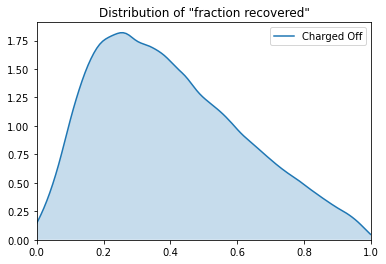

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.kdeplot(
    data=loans["fraction_recovered"][loans["loan_status"] == "Charged Off"],
    label="Charged Off",
    shade=True,
)
plt.axis(xmin=0, xmax=1)
plt.title('Distribution of "fraction recovered"')
plt.show()

Now that the output is formatted, it's time to clean up the inputs. I'll check the null counts of each variable.

In [14]:
loans.drop(columns=cols_for_output, inplace=True)
loans.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1348059 entries, 0 to 2260697
Data columns (total 97 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   loan_amnt                            1348059 non-null  float64
 1   term                                 1348059 non-null  object 
 2   emp_length                           1269514 non-null  object 
 3   home_ownership                       1348059 non-null  object 
 4   annual_inc                           1348055 non-null  float64
 5   verification_status                  1348059 non-null  object 
 6   issue_d                              1348059 non-null  object 
 7   loan_status                          1348059 non-null  object 
 8   purpose                              1348059 non-null  object 
 9   dti                                  1347685 non-null  float64
 10  delinq_2yrs                          1348030 non-null  float64
 11

Remaining columns with lots of null values seem to fall into three categories:

1. Derogatory/delinquency metrics (where null means the borrower doesn't have any such marks)
  - I'll also add `mths_since_recent_inq` to this list, since its non-null count is below what seems to be the threshold for complete data, which is around 1,277,783. I'll assume a null value here means no recent inquiries.
2. Metrics that only apply to joint applications (where null means it was a single application)
3. An inexplicable series of 14 credit history–related columns that only have around 537,000 entries. Are these newer metrics?

In [15]:
negative_mark_cols = ["mths_since_last_delinq", "mths_since_last_record", "mths_since_last_major_derog", "mths_since_recent_bc_dlq", "mths_since_recent_inq", "mths_since_recent_revol_delinq", "mths_since_recent_revol_delinq", "sec_app_mths_since_last_major_derog"]
joint_cols = ["annual_inc_joint", "dti_joint", "verification_status_joint", "revol_bal_joint", "sec_app_fico_range_low", "sec_app_fico_range_high", "sec_app_earliest_cr_line", "sec_app_inq_last_6mths", "sec_app_mort_acc", "sec_app_open_acc", "sec_app_revol_util", "sec_app_open_act_il", "sec_app_num_rev_accts", "sec_app_chargeoff_within_12_mths", "sec_app_collections_12_mths_ex_med", "sec_app_mths_since_last_major_derog"]
confusing_cols = ["open_acc_6m", "open_act_il", "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il", "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc", "all_util", "inq_fi", "total_cu_tl", "inq_last_12m"]

I'll first look at those more confusing columns to find out whether or not they're a newer set of metrics. That'll require converting `issue_d` to date format first.

In [16]:
loans["issue_d"] = loans["issue_d"].astype("datetime64[ns]")

# Check date range of confusing columns
loans[confusing_cols + ["issue_d"]].dropna(axis="index")["issue_d"].agg(
    ["count", "min", "max"]
)

count                 464325
min      2015-12-01 00:00:00
max      2018-12-01 00:00:00
Name: issue_d, dtype: object

In [17]:
# Compare to all entries from Dec 2015 onward
loans["issue_d"][loans["issue_d"] >= np.datetime64("2015-12-01")].agg(
    ["count", "min", "max"]
)

count                 557708
min      2015-12-01 00:00:00
max      2018-12-01 00:00:00
Name: issue_d, dtype: object

It appears that these are indeed newer metrics, their use only beginning in December 2015, but even after that point usage is spotty. I'm curious to see if these additional metrics would make a model more accurate, though, so once I'm done cleaning the data I'll copy the rows with these new metrics into a new dataset and create another model using the new metrics.

In [18]:
new_metric_cols = confusing_cols

As for the derogatory/delinquency metrics, taking a cue [from Michael Wurm](https://towardsdatascience.com/intelligent-loan-selection-for-peer-to-peer-lending-575dfa2573cb), I'm going to take the inverse of all the "months since recent/last" fields, which will turn each into a proxy for the frequency of the event and also let me set all the null values (when an event has never happened) to 0. For the "months since oldest" fields, I'll just set the null values to 0 and leave the rest untouched.

In [19]:
mths_since_last_cols = [
    col_name
    for col_name in loans.columns
    if "mths_since" in col_name or "mo_sin_rcnt" in col_name
]
mths_since_old_cols = [
    col_name for col_name in loans.columns if "mo_sin_old" in col_name
]

for col_name in mths_since_last_cols:
    loans[col_name] = [
        0.0 if pd.isna(months) else 1 / 1 if months == 0 else 1 / months
        for months in loans[col_name]
    ]
loans.loc[:, mths_since_old_cols].fillna(0, inplace=True)

# Rename inverse columns
rename_mapper = {}
for col_name in mths_since_last_cols:
    rename_mapper[col_name] = col_name.replace("mths_since", "inv_mths_since").replace(
        "mo_sin_rcnt", "inv_mo_sin_rcnt"
    )
loans.rename(columns=rename_mapper, inplace=True)


def replace_list_value(l, old_value, new_value):
    i = l.index(old_value)
    l.pop(i)
    l.insert(i, new_value)


replace_list_value(new_metric_cols, "mths_since_rcnt_il", "inv_mths_since_rcnt_il")
replace_list_value(
    joint_cols,
    "sec_app_mths_since_last_major_derog",
    "sec_app_inv_mths_since_last_major_derog",
)

Now to look closer at joint loans.

In [20]:
loans.groupby("application_type")["application_type"].count()

application_type
Individual    1322259
Joint App       25800
Name: application_type, dtype: int64

In [21]:
joint_loans = loans[:][loans["application_type"] == "Joint App"]
joint_loans[joint_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25800 entries, 2 to 2260663
Data columns (total 16 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   annual_inc_joint                         25800 non-null  float64
 1   dti_joint                                25797 non-null  float64
 2   verification_status_joint                25595 non-null  object 
 3   revol_bal_joint                          18629 non-null  float64
 4   sec_app_fico_range_low                   18630 non-null  float64
 5   sec_app_fico_range_high                  18630 non-null  float64
 6   sec_app_earliest_cr_line                 18630 non-null  object 
 7   sec_app_inq_last_6mths                   18630 non-null  float64
 8   sec_app_mort_acc                         18630 non-null  float64
 9   sec_app_open_acc                         18630 non-null  float64
 10  sec_app_revol_util                       183

It seems there may be a case of newer metrics for joint applications as well. I'll investigate.

In [22]:
joint_new_metric_cols = ["revol_bal_joint", "sec_app_fico_range_low", "sec_app_fico_range_high", "sec_app_earliest_cr_line", "sec_app_inq_last_6mths", "sec_app_mort_acc", "sec_app_open_acc", "sec_app_revol_util", "sec_app_open_act_il", "sec_app_num_rev_accts", "sec_app_chargeoff_within_12_mths", "sec_app_collections_12_mths_ex_med", "sec_app_inv_mths_since_last_major_derog"]
joint_loans[joint_new_metric_cols + ["issue_d"]].dropna(axis="index")["issue_d"].agg(
    ["count", "min", "max"]
)

count                  18301
min      2017-03-01 00:00:00
max      2018-12-01 00:00:00
Name: issue_d, dtype: object

In [23]:
# Check without `sec_app_revol_util` column
joint_new_metric_cols_2 = ["revol_bal_joint", "sec_app_fico_range_low", "sec_app_fico_range_high", "sec_app_earliest_cr_line", "sec_app_inq_last_6mths", "sec_app_mort_acc", "sec_app_open_acc", "sec_app_open_act_il", "sec_app_num_rev_accts", "sec_app_chargeoff_within_12_mths", "sec_app_collections_12_mths_ex_med", "sec_app_inv_mths_since_last_major_derog"]
joint_loans[joint_new_metric_cols_2 + ["issue_d"]].dropna(axis="index")["issue_d"].agg(
    ["count", "min", "max"]
)

count                  18629
min      2017-03-01 00:00:00
max      2018-12-01 00:00:00
Name: issue_d, dtype: object

Newer than the previous set of new metrics, even—these didn't start getting used till March 2017. Now I wonder when joint loans were first introduced.

In [24]:
joint_loans["issue_d"].agg(["count", "min", "max"])

count                  25800
min      2015-10-01 00:00:00
max      2018-12-01 00:00:00
Name: issue_d, dtype: object

2015\. I think I'll save the newer joint metrics for perhaps a third model, but I believe I can include `annual_inc_joint`, `dti_joint`, and `verification_status_joint` in the main model—I'll just binary-encode `application_type`, and for individual applications I'll set `annual_inc_joint`, `dti_joint`, and `verification_status_joint` equal to their non-joint counterparts.

In [25]:
onehot_cols.append("application_type")

# Fill joint columns in individual applications
for joint_col, indiv_col in zip(
    ["annual_inc_joint", "dti_joint", "verification_status_joint"],
    ["annual_inc", "dti", "verification_status"],
):
    loans[joint_col] = [
        joint_val if app_type == "Joint App" else indiv_val
        for app_type, joint_val, indiv_val in zip(
            loans["application_type"], loans[joint_col], loans[indiv_col]
        )
    ]

loans.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1348059 entries, 0 to 2260697
Data columns (total 97 columns):
 #   Column                                   Non-Null Count    Dtype         
---  ------                                   --------------    -----         
 0   loan_amnt                                1348059 non-null  float64       
 1   term                                     1348059 non-null  object        
 2   emp_length                               1269514 non-null  object        
 3   home_ownership                           1348059 non-null  object        
 4   annual_inc                               1348055 non-null  float64       
 5   verification_status                      1348059 non-null  object        
 6   issue_d                                  1348059 non-null  datetime64[ns]
 7   loan_status                              1348059 non-null  object        
 8   purpose                                  1348059 non-null  object        
 9   dti          

Now the only remaining steps should be removing rows with null values (in columns that aren't new metrics) and encoding categorical features.

I'm _removing_ rows with null values in those columns because that should still leave the vast majority of rows intact, over 1 million, which is still plenty of data. But I guess I should make sure before I overwrite `loans`.

In [26]:
cols_to_search = [
    col for col in loans.columns if col not in new_metric_cols + joint_new_metric_cols
]
loans.dropna(axis="index", subset=cols_to_search).shape

(1110171, 97)

Yes, still 1,110,171. That'll do.

In [27]:
loans.dropna(axis="index", subset=cols_to_search, inplace=True)

Then actually I'll tackle `earliest_cr_line` and its joint counterpart first before looking at the categorical features.

In [28]:
loans[["earliest_cr_line", "sec_app_earliest_cr_line"]]

,earliest_cr_line,sec_app_earliest_cr_line
0,Aug-2003,NaN
1,Dec-1999,NaN
2,Aug-2000,NaN
4,Jun-1998,NaN
5,Oct-1987,NaN
...,...,...
2260688,Jul-2004,NaN
2260690,Mar-2002,NaN
2260691,Jun-2011,NaN
2260692,Aug-1997,NaN


I should convert that to the age of the credit line at the time of application (or the time of loan issuing, more precisely).

In [29]:
def get_credit_history_age(col_name):
    earliest_cr_line_date = loans[col_name].astype("datetime64[ns]")
    cr_hist_age_delta = loans["issue_d"] - earliest_cr_line_date
    MINUTES_PER_MONTH = int(365.25 / 12 * 24 * 60)
    cr_hist_age_months = cr_hist_age_delta / np.timedelta64(MINUTES_PER_MONTH, "m")
    return cr_hist_age_months.map(
        lambda value: np.nan if pd.isna(value) else round(value)
    )


cr_hist_age_months = get_credit_history_age("earliest_cr_line")
cr_hist_age_months

0          148
1          192
2          184
4          210
5          338
          ... 
2260688    147
2260690    175
2260691     64
2260692    230
2260697    207
Length: 1110171, dtype: int64

In [30]:
loans["earliest_cr_line"] = cr_hist_age_months
loans["sec_app_earliest_cr_line"] = get_credit_history_age(
    "sec_app_earliest_cr_line"
).astype("Int64")
loans.rename(
    columns={
        "earliest_cr_line": "cr_hist_age_mths",
        "sec_app_earliest_cr_line": "sec_app_cr_hist_age_mths",
    },
    inplace=True,
)
replace_list_value(
    joint_new_metric_cols, "sec_app_earliest_cr_line", "sec_app_cr_hist_age_mths"
)

_Now_ a look at those categorical features.

In [31]:
categorical_cols = ["term", "emp_length", "home_ownership", "verification_status", "purpose", "verification_status_joint"]
for i, col_name in enumerate(categorical_cols):
    print(
        loans.groupby(col_name)[col_name].count(),
        "\n" if i < len(categorical_cols) - 1 else "",
    )

term
36 months    831601
60 months    278570
Name: term, dtype: int64 

emp_length
1 year        76868
10+ years    392883
2 years      106124
3 years       93784
4 years       69031
5 years       72421
6 years       54240
7 years       52229
8 years       53826
9 years       45210
< 1 year      93555
Name: emp_length, dtype: int64 

home_ownership
ANY            250
MORTGAGE    559035
NONE            39
OTHER           40
OWN         114577
RENT        436230
Name: home_ownership, dtype: int64 

verification_status
Not Verified       335350
Source Verified    463153
Verified           311668
Name: verification_status, dtype: int64 

purpose
car                    10754
credit_card           245942
debt_consolidation    653222
educational                1
home_improvement       71089
house                   5720
major_purchase         22901
medical                12302
moving                  7464
other                  60986
renewable_energy         691
small_business         11137
va

First, in researching income verification, I learned that LendingClub only tries to [verify income](https://www.lendingclub.com/investing/investor-education/income-verification) on a subset of loan applications based on the content of the application, so this feature is a source of target leakage. I'll remove the two offending columns (and a couple more I don't need anymore).

In [32]:
loans.drop(
    columns=[
        "verification_status",
        "verification_status_joint",
        "issue_d",
        "loan_status",
    ],
    inplace=True,
)

Once I create my pipeline, I'll binary encode `term`, one-hot encode `home_ownership` and `purpose`, and since `emp_length` is an ordinal variable, I'll convert it to the integers 0–10.

In [33]:
onehot_cols += ["home_ownership", "purpose"]
ordinal_cols = {
    "emp_length": [
        "< 1 year",
        "1 year",
        "2 years",
        "3 years",
        "4 years",
        "5 years",
        "6 years",
        "7 years",
        "8 years",
        "9 years",
        "10+ years",
    ]
}

That should cover all the cleaning necessary for the first model's data. I'll save the columns that'll be used in the first model to a new DataFrame, and while I'm at it, I'll start formatting the DataFrames for the two additional models adding the two sets of new metrics.

In [34]:
loans_1 = loans.drop(columns=new_metric_cols + joint_new_metric_cols)
loans_2 = loans.drop(columns=joint_new_metric_cols)
loans_2.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1110171 entries, 0 to 2260697
Data columns (total 80 columns):
 #   Column                              Non-Null Count    Dtype  
---  ------                              --------------    -----  
 0   loan_amnt                           1110171 non-null  float64
 1   term                                1110171 non-null  object 
 2   emp_length                          1110171 non-null  object 
 3   home_ownership                      1110171 non-null  object 
 4   annual_inc                          1110171 non-null  float64
 5   purpose                             1110171 non-null  object 
 6   dti                                 1110171 non-null  float64
 7   delinq_2yrs                         1110171 non-null  float64
 8   cr_hist_age_mths                    1110171 non-null  int64  
 9   fico_range_low                      1110171 non-null  float64
 10  fico_range_high                     1110171 non-null  float64
 11  inq_last_6m

Before I drop a bunch of rows with nulls from `loans_2`, I'm concerned about `il_util`, as it's missing values in about 50,000 more rows than the rest of the new metric columns. Why would that be?

In [35]:
loans_2["il_util"][loans_2["il_util"].notna()].describe()

count    408722.000000
mean         71.832894
std          22.311439
min           0.000000
25%          59.000000
50%          75.000000
75%          87.000000
max         464.000000
Name: il_util, dtype: float64

Peeking back up to the data dictionary, `il_util` is the "ratio of total current balance to high credit/credit limit on all install acct". The relevant balance (`total_bal_il`) and credit limit (`total_il_high_credit_limit`) metrics appear to already be in the data, so perhaps this utilization metric doesn't contain any new information. I'll compare `il_util` (where it's present) to the ratio of the other two variables.

In [36]:
query_df = loans[["il_util", "total_bal_il", "total_il_high_credit_limit"]].dropna(
    axis="index", subset=["il_util"]
)
query_df["il_util_compute"] = (
    query_df["total_bal_il"] / query_df["total_il_high_credit_limit"]
).map(lambda x: float(round(x * 100)))
query_df[["il_util", "il_util_compute"]]

,il_util,il_util_compute
0,36.0,36.0
1,73.0,73.0
2,73.0,73.0
4,84.0,84.0
5,99.0,99.0
...,...,...
2260688,52.0,39.0
2260690,50.0,74.0
2260691,47.0,47.0
2260692,79.0,79.0


In [37]:
(query_df["il_util"] == query_df["il_util_compute"]).describe()

count     408722
unique         2
top         True
freq      307589
dtype: object

In [38]:
query_df["compute_diff"] = abs(query_df["il_util"] - query_df["il_util_compute"])
query_df["compute_diff"][query_df["compute_diff"] != 0].describe()

count    101133.000000
mean         14.638684
std          16.409913
min           1.000000
25%           3.000000
50%          10.000000
75%          21.000000
max        1108.000000
Name: compute_diff, dtype: float64

That's weird. `il_util` is equal to the computed ratio three-quarters of the time, but when it's off, the median difference is 10 points off. Perhaps there's new information there sometimes after all. Maybe whatever credit bureau is reporting the utilization rate uses a different formula than just a simple ratio? Again, something I could ask if I were performing this analysis for a client, but that's not the case. I'll assume that this variable is still valuable, and where `il_util` is null I'll impute the value to make it equal to the ratio of `total_bal_il` to `total_il_high_credit_limit` (or 0 if the limit is 0). And I'll add one more boolean field to mark the imputed entries.

Also, that 1,108 is a doozy of an outlier, but I think I'll just leave it be, as it appears that [outliers aren't too big a deal](https://medium.com/analytics-vidhya/effect-of-outliers-on-neural-networks-performance-ca1d9185dce9) if the neural network architecture is sufficiently deep.

In [39]:
loans["il_util_imputed"] = [
    True if pd.isna(util) & pd.notna(bal) & pd.notna(limit) else False
    for util, bal, limit in zip(
        loans["il_util"], loans["total_bal_il"], loans["total_il_high_credit_limit"]
    )
]
new_metric_onehot_cols = ["il_util_imputed"]
loans["il_util"] = [
    0.0
    if pd.isna(util) & pd.notna(bal) & (limit == 0)
    else float(round(bal / limit * 100))
    if pd.isna(util) & pd.notna(bal) & pd.notna(limit)
    else util
    for util, bal, limit in zip(
        loans["il_util"], loans["total_bal_il"], loans["total_il_high_credit_limit"]
    )
]

loans_2 = loans.drop(columns=joint_new_metric_cols)
loans_2.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1110171 entries, 0 to 2260697
Data columns (total 81 columns):
 #   Column                              Non-Null Count    Dtype  
---  ------                              --------------    -----  
 0   loan_amnt                           1110171 non-null  float64
 1   term                                1110171 non-null  object 
 2   emp_length                          1110171 non-null  object 
 3   home_ownership                      1110171 non-null  object 
 4   annual_inc                          1110171 non-null  float64
 5   purpose                             1110171 non-null  object 
 6   dti                                 1110171 non-null  float64
 7   delinq_2yrs                         1110171 non-null  float64
 8   cr_hist_age_mths                    1110171 non-null  int64  
 9   fico_range_low                      1110171 non-null  float64
 10  fico_range_high                     1110171 non-null  float64
 11  inq_last_6m

Good. Ready to drop rows with nulls in `loans_2` and move on to the DataFrame for the model that adds the new metrics for joint applications.

In [40]:
loans_2.dropna(axis="index", inplace=True)

loans_3 = loans.dropna(axis="index")
loans_3.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14453 entries, 421222 to 2157147
Data columns (total 94 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   loan_amnt                                14453 non-null  float64
 1   term                                     14453 non-null  object 
 2   emp_length                               14453 non-null  object 
 3   home_ownership                           14453 non-null  object 
 4   annual_inc                               14453 non-null  float64
 5   purpose                                  14453 non-null  object 
 6   dti                                      14453 non-null  float64
 7   delinq_2yrs                              14453 non-null  float64
 8   cr_hist_age_mths                         14453 non-null  int64  
 9   fico_range_low                           14453 non-null  float64
 10  fico_range_high                        

Phew, the data's all clean now! Time for the fun part.

## Building the neural networks

After a good deal of trial and error, I found that a network architecture with one hidden layer with a number of nodes around two-thirds the number of input nodes was as good as I could find. I used ReLU activation in that hidden layer, and adam optimization and a loss metric of mean absolute error in the model as a whole.

The dataset being so large, I had great results with a batch size of 128 for my first two models, but I had to decrease that to 32 for the third.

In [41]:
from sklearn.model_selection import train_test_split
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from math import floor


def run_pipeline(
    data,
    onehot_cols,
    ordinal_cols,
    batch_size,
    epochs=100,
    early_stop=False,
    validate=True,
):
    X = data.drop(columns=["fraction_recovered"])
    y = data["fraction_recovered"]
    X_train, X_valid, y_train, y_valid = (
        train_test_split(X, y, test_size=0.2, random_state=0)
        if validate
        else (X, None, y, None)
    )

    transformer = DataFrameMapper(
        [
            (onehot_cols, OneHotEncoder(drop="if_binary")),
            (
                list(ordinal_cols.keys()),
                OrdinalEncoder(categories=list(ordinal_cols.values())),
            ),
        ],
        default=StandardScaler(),
    )

    X_train = transformer.fit_transform(X_train)
    X_valid = transformer.transform(X_valid) if validate else None

    input_nodes = X_train.shape[1]
    output_nodes = 1
    hidden_nodes = floor(input_nodes * 2 / 3) + output_nodes

    model = Sequential()
    model.add(Input((input_nodes,)))
    model.add(Dense(hidden_nodes, activation="relu"))
    model.add(Dense(output_nodes))
    model.compile(optimizer="adam", loss="mean_absolute_error")

    history = model.fit(
        X_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_valid, y_valid) if validate else None,
        callbacks=EarlyStopping(
            monitor="val_loss", patience=20, restore_best_weights=True
        )
        if early_stop
        else None,
        verbose=1,
    )

    # Create a predictor that automatically transforms inputs
    def model_predict(pred_input):
        X_pred = transformer.transform(pred_input)
        return model.predict(X_pred)

    return history.history, model, transformer


print("Model 1:")
history_1, _, _ = run_pipeline(
    loans_1, onehot_cols, ordinal_cols, batch_size=128, early_stop=True,
)
print("\nModel 2:")
history_2, _, _ = run_pipeline(
    loans_2,
    onehot_cols + new_metric_onehot_cols,
    ordinal_cols,
    batch_size=128,
    early_stop=True,
)
print("\nModel 3:")
history_3, _, _ = run_pipeline(
    loans_3,
    onehot_cols + new_metric_onehot_cols,
    ordinal_cols,
    batch_size=32,
    early_stop=True,
)

Model 1:
Epoch 1/100
6939/6939 [==============================] - 13s 2ms/step - loss: 0.1363 - val_loss: 0.1222
Epoch 2/100
6939/6939 [==============================] - 13s 2ms/step - loss: 0.1200 - val_loss: 0.1198
Epoch 3/100
6939/6939 [==============================] - 13s 2ms/step - loss: 0.1186 - val_loss: 0.1178
Epoch 4/100
6939/6939 [==============================] - 13s 2ms/step - loss: 0.1180 - val_loss: 0.1176
Epoch 5/100
6939/6939 [==============================] - 14s 2ms/step - loss: 0.1176 - val_loss: 0.1174
Epoch 6/100
6939/6939 [==============================] - 13s 2ms/step - loss: 0.1173 - val_loss: 0.1173
Epoch 7/100
6939/6939 [==============================] - 13s 2ms/step - loss: 0.1170 - val_loss: 0.1171
Epoch 8/100
6939/6939 [==============================] - 13s 2ms/step - loss: 0.1169 - val_loss: 0.1168
Epoch 9/100
6939/6939 [==============================] - 13s 2ms/step - loss: 0.1168 - val_loss: 0.1176
Epoch 10/100
6939/6939 [==============================]

2873/2873 [==============================] - 5s 2ms/step - loss: 0.1418 - val_loss: 0.1408
Epoch 11/100
2873/2873 [==============================] - 5s 2ms/step - loss: 0.1416 - val_loss: 0.1405
Epoch 12/100
2873/2873 [==============================] - 5s 2ms/step - loss: 0.1415 - val_loss: 0.1410
Epoch 13/100
2873/2873 [==============================] - 6s 2ms/step - loss: 0.1412 - val_loss: 0.1408
Epoch 14/100
2873/2873 [==============================] - 5s 2ms/step - loss: 0.1411 - val_loss: 0.1403
Epoch 15/100
2873/2873 [==============================] - 5s 2ms/step - loss: 0.1410 - val_loss: 0.1407
Epoch 16/100
2873/2873 [==============================] - 5s 2ms/step - loss: 0.1409 - val_loss: 0.1398
Epoch 17/100
2873/2873 [==============================] - 5s 2ms/step - loss: 0.1408 - val_loss: 0.1404
Epoch 18/100
2873/2873 [==============================] - 5s 2ms/step - loss: 0.1407 - val_loss: 0.1404
Epoch 19/100
2873/2873 [==============================] - 5s 2ms/step - loss:

Epoch 89/100
2873/2873 [==============================] - 5s 2ms/step - loss: 0.1387 - val_loss: 0.1392
Epoch 90/100
2873/2873 [==============================] - 5s 2ms/step - loss: 0.1386 - val_loss: 0.1394
Epoch 91/100
2873/2873 [==============================] - 5s 2ms/step - loss: 0.1387 - val_loss: 0.1393
Epoch 92/100
2873/2873 [==============================] - 5s 2ms/step - loss: 0.1387 - val_loss: 0.1393
Epoch 93/100
2873/2873 [==============================] - 5s 2ms/step - loss: 0.1387 - val_loss: 0.1394
Epoch 94/100
2873/2873 [==============================] - 5s 2ms/step - loss: 0.1387 - val_loss: 0.1392
Epoch 95/100
2873/2873 [==============================] - 5s 2ms/step - loss: 0.1386 - val_loss: 0.1391
Epoch 96/100
2873/2873 [==============================] - 5s 2ms/step - loss: 0.1387 - val_loss: 0.1390
Epoch 97/100
2873/2873 [==============================] - 5s 2ms/step - loss: 0.1386 - val_loss: 0.1391
Epoch 98/100
2873/2873 [==============================] - 5s 2ms

The first model performed best, settling around a mean absolute error of 0.1159 in the validation set at 48 epochs (though it seems even after setting `random_state` inside `train_test_split`, there's still a bit of entropy left in the training of the model, so the particular epoch number may change if you run this notebook yourself). Apparently the additional _records_ in the first dataset did more to aid in training than the additional _metrics_ in the subsequent sets.

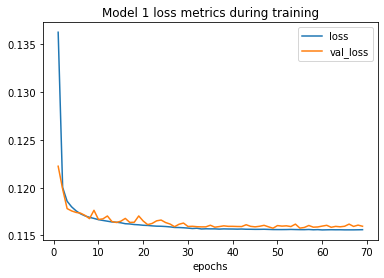

In [42]:
epochs_1 = len(history_1["loss"])
sns.lineplot(x=range(1, epochs_1 + 1), y=history_1["loss"], label="loss")
sns.lineplot(x=range(1, epochs_1 + 1), y=history_1["val_loss"], label="val_loss")
plt.xlabel("epochs")
plt.title("Model 1 loss metrics during training")
plt.show()

## Saving the final model

First I need to _create_ the final model, training `model_1`'s architecture on the full dataset. Then I'll save the model to disk with its `save` function and save the data transformer using joblib so I can use it in the API.

In [43]:
import joblib

_, final_model, final_transformer = run_pipeline(
    loans_1,
    onehot_cols,
    ordinal_cols,
    batch_size=128,
    epochs=epochs_1 - 20,
    early_stop=False,
    validate=False,
)

final_model.save("loan_risk_model")
joblib.dump(final_transformer, "data_transformer.joblib")

Epoch 1/49
8674/8674 [==============================] - 13s 2ms/step - loss: 0.1323
Epoch 2/49
8674/8674 [==============================] - 14s 2ms/step - loss: 0.1198
Epoch 3/49
8674/8674 [==============================] - 15s 2ms/step - loss: 0.1187
Epoch 4/49
8674/8674 [==============================] - 13s 2ms/step - loss: 0.1181
Epoch 5/49
8674/8674 [==============================] - 13s 2ms/step - loss: 0.1177
Epoch 6/49
8674/8674 [==============================] - 13s 2ms/step - loss: 0.1174
Epoch 7/49
8674/8674 [==============================] - 14s 2ms/step - loss: 0.1172
Epoch 8/49
8674/8674 [==============================] - 15s 2ms/step - loss: 0.1170
Epoch 9/49
8674/8674 [==============================] - 13s 2ms/step - loss: 0.1168
Epoch 10/49
8674/8674 [==============================] - 14s 2ms/step - loss: 0.1167
Epoch 11/49
8674/8674 [==============================] - 14s 2ms/step - loss: 0.1165
Epoch 12/49
8674/8674 [==============================] - 14s 2ms/step - lo

['data_transformer.joblib']

## Building the API

I first tried building this API and its demonstrational front end on [Glitch](https://glitch.com/), which, officially, only supports Node.js back ends, but unofficially you can get a Python server running there (which I've [done before](https://ty-metricimpconverter-python.glitch.me/ "Python metric-imperial converter microservice – Ty Mick") using [Flask](https://flask.palletsprojects.com/)). When I was almost finished, though, I tried importing TensorFlow to load my model, and it was then that I discovered that unlike Node.js dependencies, Python dependencies get installed to your project's disk space on Glitch, and not even their pro plan provides enough space to contain the entire TensorFlow library. Which totally makes sense—I certainly wasn't using the platform as intended.

Then I discovered [PythonAnywhere](https://www.pythonanywhere.com/)! They have plenty of common Python libraries already installed out-of-the-box, including TensorFlow, so I got everything working perfectly there.

So [head on over](https://tywmick.pythonanywhere.com/ "Neural Network Loan Risk Prediction API – Ty Mick") if you'd like to check it out; the front end includes a form where you can fill in all the parameters for the API request, and it's prefilled with the median numeric values and most common categorical values from the dataset (since there are a lot to fill in). Or you can send a GET request to `https://tywmick.pythonanywhere.com/api/predict` if you really want to include every parameter in your query string. In either case, you're also more than welcome to take a look at its source [on GitHub](https://github.com/tywmick/loan-risk-neural-network).

-----

One of the best/worst things about machine learning is that your models _always_ have room for improvement. I mentioned a couple ideas along the way above for how I could improve the model in the future, but what's the first thing you would tweak in this model? I'd love to hear in the comments below.